In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, unitsNumber = 64): 
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return dense_2_dropout

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

single_category_layer = concatenate([
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
])

output_layer = Dense(6, activation='sigmoid')(concatenate([dense_2_dropout, single_category_layer]))

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 8:23 - loss: 0.1603 - acc: 0.9391

 97856/102124 [===========================>..] - ETA: 25s - loss: 0.0881 - acc: 0.9683

102124/102124 [==============================] - 645s 6ms/step - loss: 0.0870 - acc: 0.9688 - val_loss: 0.0487 - val_acc: 0.9819
Epoch 2/32
 12416/102124 [==>...........................] - ETA: 8:44 - loss: 0.0611 - acc: 0.9783

 64128/102124 [=================>............] - ETA: 3:41 - loss: 0.0594 - acc: 0.9788

102112/102124 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9790

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0583 - acc: 0.9790 - val_loss: 0.0545 - val_acc: 0.9800
roc-auc: 0.9802 - roc-auc_val: 0.9795                                                                                                    
Epoch 3/32
  8704/102124 [=>............................] - ETA: 9:05 - loss: 0.0578 - acc: 0.9792

 51616/102124 [==============>...............] - ETA: 4:55 - loss: 0.0544 - acc: 0.9799

102112/102124 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9803

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0533 - acc: 0.9802 - val_loss: 0.1004 - val_acc: 0.9626

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004061262006871402.
Epoch 4/32
  8064/102124 [=>............................] - ETA: 9:10 - loss: 0.0516 - acc: 0.9809

 85792/102124 [========================>.....] - ETA: 1:35 - loss: 0.0512 - acc: 0.9808

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0507 - acc: 0.9810 - val_loss: 0.0489 - val_acc: 0.9825
roc-auc: 0.984 - roc-auc_val: 0.9817                                                                                                    
Epoch 5/32
  4864/102124 [>.............................] - ETA: 9:26 - loss: 0.0479 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9818

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0483 - acc: 0.9818 - val_loss: 0.0462 - val_acc: 0.9826
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 8:34 - loss: 0.0479 - acc: 0.9820

 72704/102124 [====================>.........] - ETA: 2:51 - loss: 0.0465 - acc: 0.9823

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0466 - acc: 0.9821 - val_loss: 0.0418 - val_acc: 0.9839
roc-auc: 0.9892 - roc-auc_val: 0.987                                                                                                    
Epoch 7/32
  1728/102124 [..............................] - ETA: 9:45 - loss: 0.0528 - acc: 0.9796

 48224/102124 [=============>................] - ETA: 5:14 - loss: 0.0450 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9824

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0457 - acc: 0.9824 - val_loss: 0.0417 - val_acc: 0.9841
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:33 - loss: 0.0439 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9829

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0446 - acc: 0.9828 - val_loss: 0.0424 - val_acc: 0.9833
roc-auc: 0.9897 - roc-auc_val: 0.9867                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 9:02 - loss: 0.0458 - acc: 0.9821

 72736/102124 [====================>.........] - ETA: 2:51 - loss: 0.0434 - acc: 0.9831

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0438 - acc: 0.9830 - val_loss: 0.0424 - val_acc: 0.9837
Epoch 10/32
  2848/102124 [..............................] - ETA: 9:36 - loss: 0.0430 - acc: 0.9826

 99520/102124 [============================>.] - ETA: 15s - loss: 0.0429 - acc: 0.9832

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0430 - acc: 0.9832 - val_loss: 0.0408 - val_acc: 0.9841
roc-auc: 0.992 - roc-auc_val: 0.9873                                                                                                    
Epoch 11/32
  8128/102124 [=>............................] - ETA: 9:05 - loss: 0.0440 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9836

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0424 - acc: 0.9836 - val_loss: 0.0468 - val_acc: 0.9833
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 8:33 - loss: 0.0413 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9837

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0418 - acc: 0.9837 - val_loss: 0.0410 - val_acc: 0.9843
roc-auc: 0.9913 - roc-auc_val: 0.9871                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 9:05 - loss: 0.0421 - acc: 0.9834

 94528/102124 [==========================>...] - ETA: 44s - loss: 0.0411 - acc: 0.9839

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.0417 - val_acc: 0.9840
Epoch 14/32
 11136/102124 [==>...........................] - ETA: 8:51 - loss: 0.0410 - acc: 0.9838

 64896/102124 [==================>...........] - ETA: 3:37 - loss: 0.0398 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9841

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0403 - acc: 0.9841 - val_loss: 0.0412 - val_acc: 0.9842

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00012940811575390399.
roc-auc: 0.9911 - roc-auc_val: 0.9857                                                                                                    
Epoch 15/32
  5952/102124 [>.............................] - ETA: 9:20 - loss: 0.0405 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9842

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0416 - val_acc: 0.9844
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:34 - loss: 0.0395 - acc: 0.9845

 60096/102124 [================>.............] - ETA: 4:05 - loss: 0.0393 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9844

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0395 - acc: 0.9844 - val_loss: 0.0404 - val_acc: 0.9843
roc-auc: 0.9928 - roc-auc_val: 0.9874                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 9:04 - loss: 0.0387 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9846

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0387 - acc: 0.9846 - val_loss: 0.0426 - val_acc: 0.9841
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:34 - loss: 0.0387 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9848

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0385 - acc: 0.9848 - val_loss: 0.0406 - val_acc: 0.9845
roc-auc: 0.9928 - roc-auc_val: 0.9853                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 9:04 - loss: 0.0362 - acc: 0.9850

 73152/102124 [====================>.........] - ETA: 2:48 - loss: 0.0376 - acc: 0.9850

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0380 - acc: 0.9848 - val_loss: 0.0419 - val_acc: 0.9841
Epoch 20/32
  2976/102124 [..............................] - ETA: 9:42 - loss: 0.0388 - acc: 0.9847

 55296/102124 [===============>..............] - ETA: 4:33 - loss: 0.0382 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9851

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0417 - val_acc: 0.9841
roc-auc: 0.9926 - roc-auc_val: 0.9845                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 9:04 - loss: 0.0375 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9850

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0373 - acc: 0.9850 - val_loss: 0.0415 - val_acc: 0.9842
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:34 - loss: 0.0357 - acc: 0.9855

101344/102124 [============================>.] - ETA: 4s - loss: 0.0370 - acc: 0.9854

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0371 - acc: 0.9854 - val_loss: 0.0423 - val_acc: 0.9842
roc-auc: 0.9932 - roc-auc_val: 0.9846                                                                                                    
Epoch 23/32
  8544/102124 [=>............................] - ETA: 9:04 - loss: 0.0364 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9853

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0413 - val_acc: 0.9844
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 8:31 - loss: 0.0354 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9854

102124/102124 [==============================] - 633s 6ms/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0419 - val_acc: 0.9843
roc-auc: 0.994 - roc-auc_val: 0.985                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 9:04 - loss: 0.0347 - acc: 0.9861

 74560/102124 [====================>.........] - ETA: 2:40 - loss: 0.0361 - acc: 0.9856

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0409 - val_acc: 0.9845

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.123462349525653e-05.
Epoch 26/32
  2592/102124 [..............................] - ETA: 9:40 - loss: 0.0367 - acc: 0.9844

 47232/102124 [============>.................] - ETA: 5:20 - loss: 0.0367 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9854

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0364 - acc: 0.9854 - val_loss: 0.0418 - val_acc: 0.9843
roc-auc: 0.9942 - roc-auc_val: 0.9849                                                                                                    


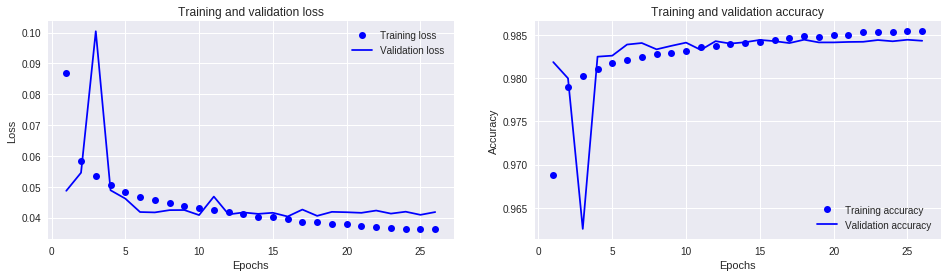

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 55s 2ms/step
([0.03931944428842568, 0.9847354820430905], 0.9889731102206577)
